Basic Convolutional Neural Network (Convnet) implemented in Keras to classify pictures of cats and dogs.

Inspiration for this notebook comes from this [Keras blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) and the [VGG ConvNet paper](https://arxiv.org/pdf/1409.1556.pdf), notebook shamefully stolen from [Jeff Delaney](https://www.kaggle.com/jeffd23). 


In [5]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

/home/paperspace/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Preparing the Data

This function resizes the images to 256x256 and samples 20000 images of the data to run efficiently as a Kaggle Kernel. I also separated kitties and puppies for exploratory analysis. 

In [6]:
import os, cv2, random
import numpy as np
import pandas as pd

TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

ROWS = 256
COLS = 256
ROWS2 = 64
COLS2 = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:10000] + train_cats[:10000]
random.shuffle(train_images)
test_images =  test_images[:1000]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2, (ROWS2, COLS2), interpolation=cv2.INTER_CUBIC)

def read_image2(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS2, COLS2), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

def prep_data2(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image2(image_file)
        data[i] = image.T
        if i%500 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)
test2 = prep_data2(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 20000
Processed 1000 of 20000
Processed 2000 of 20000
Processed 3000 of 20000
Processed 4000 of 20000
Processed 5000 of 20000
Processed 6000 of 20000
Processed 7000 of 20000
Processed 8000 of 20000
Processed 9000 of 20000
Processed 10000 of 20000
Processed 11000 of 20000
Processed 12000 of 20000
Processed 13000 of 20000
Processed 14000 of 20000
Processed 15000 of 20000
Processed 16000 of 20000
Processed 17000 of 20000
Processed 18000 of 20000
Processed 19000 of 20000
Processed 0 of 1000
Processed 0 of 1000
Processed 500 of 1000
Train shape: (20000, 3, 64, 64)
Test shape: (1000, 3, 64, 64)


### Generating the Labels

We're dealing with a binary classification problem here - (1) dog (0) cat. The lables can be created by looping over the file names in the train directory. The graph shows us that the training data has an equal number of cats and dogs.

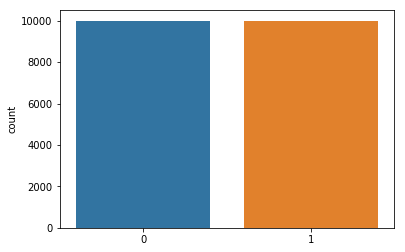

In [7]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)

### Checking out the Cats and Dogs
The best part: what do these catts & dogs actually look like? **hint: this is the best part!**

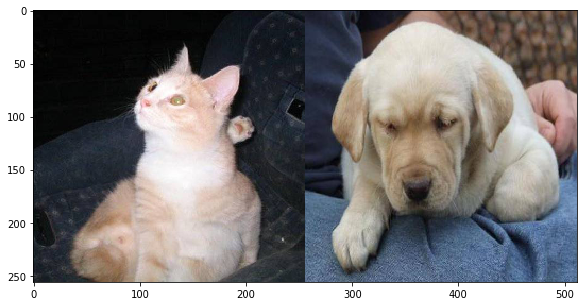

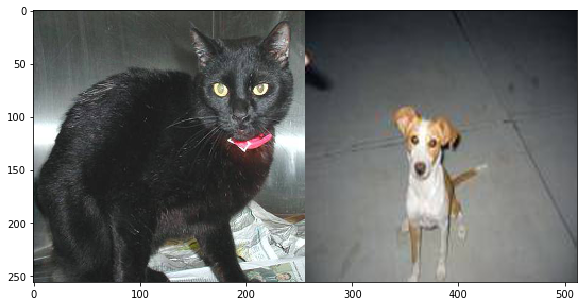

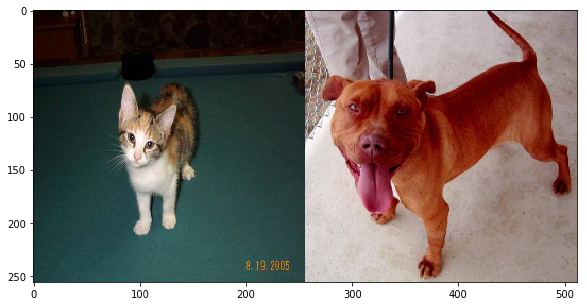

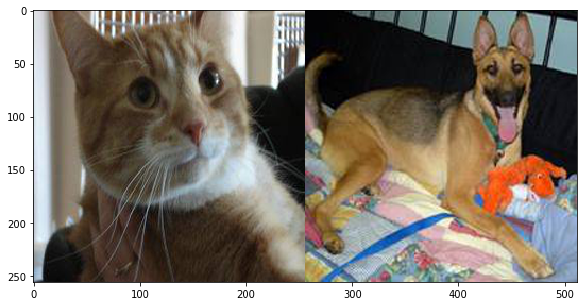

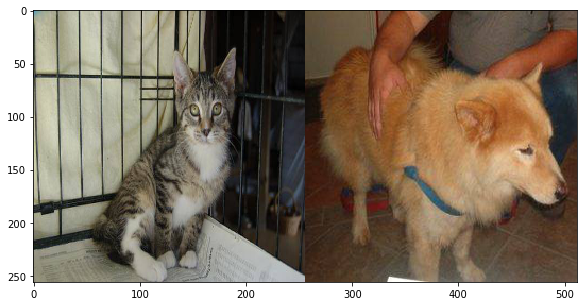

In [8]:
def show_cats_and_dogs(idx):
    cat = read_image2(train_cats[idx])
    dog = read_image2(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

## CatdogNet-16

A scaled down version of the VGG-16, with a few notable changes.

- Number of convolution filters cut in half, fully connected (dense) layers scaled down. 
- Optimizer changed to `RMSprop`. 
- Output layer activation set to `sigmoid` for binary crossentropy. 
- Some layers commented out for efficiency.

The full network takes about 80s per epoch on a GTX1070 (or 2hr+ on CPU) on the full dataset.  (This script only trains on 8% of the 25K images. )

In [9]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Conv2D(32, 3, padding='same', input_shape=train.shape[1:], activation='relu'))
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("First layer...")
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("Second layer...")
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("Third layer...")
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #print("Flattening, etc...")
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    print("Compiling model...")
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

print("Creating model:")
model = catdog()

Creating model:
Compiling model...


### Train and Predict

Here we train the model until the validation loss stops improving, so the model doesn't overfit. We can also track the loss history in order to visually see the improvement with each iteration.

Then we can use the trained model to predict whether images from the test dataset are cats or dogs (with a predicted probability for each).

running model...
Train on 15000 samples, validate on 5000 samples
Epoch 1/10
 - 9s - loss: 0.6318 - acc: 0.6433 - val_loss: 0.6379 - val_acc: 0.6296
Epoch 2/10
 - 9s - loss: 0.6092 - acc: 0.6677 - val_loss: 0.5905 - val_acc: 0.6878
Epoch 3/10
 - 9s - loss: 0.5951 - acc: 0.6842 - val_loss: 0.5978 - val_acc: 0.6822
Epoch 4/10
 - 9s - loss: 0.5865 - acc: 0.6947 - val_loss: 0.5971 - val_acc: 0.6826
Epoch 5/10
 - 9s - loss: 0.5817 - acc: 0.7009 - val_loss: 0.5911 - val_acc: 0.6888
Epoch 00005: early stopping
making predictions on test set...


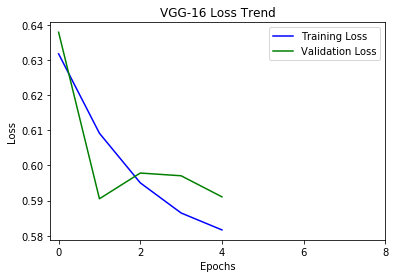

In [11]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

epochs = 10
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
       

def run_catdog():
    
    history = LossHistory()
    print("running model...")
    model.fit(train, labels, batch_size=batch_size, epochs=epochs,
              validation_split=0.25, verbose=2, shuffle=True, callbacks=[history, early_stopping])
    
    print("making predictions on test set...")
    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

loss = history.losses
val_loss = history.val_losses


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

## How'd We Do?

Humans are very good at distinguising cats vs. dogs, but how well does our model perform? Below are some examples from the test data set.

**to do: create confusion matrix and/or ROC curve**


I am 64.01% sure this is a Dog


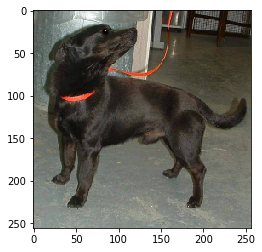

I am 58.58% sure this is a Cat


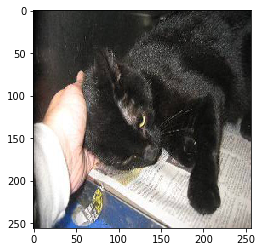

I am 62.77% sure this is a Dog


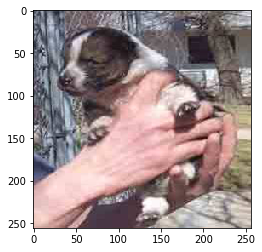

I am 93.37% sure this is a Dog


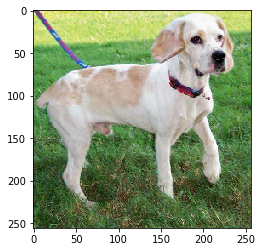

I am 57.65% sure this is a Cat


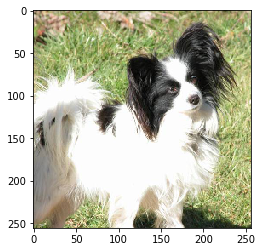

I am 59.32% sure this is a Cat


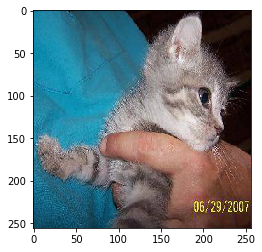

I am 70.43% sure this is a Cat


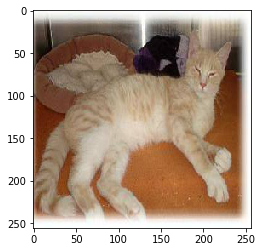

I am 97.06% sure this is a Dog


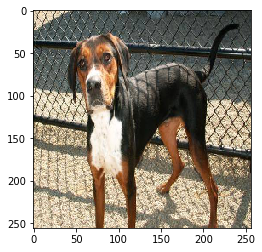

I am 50.00% sure this is a Cat


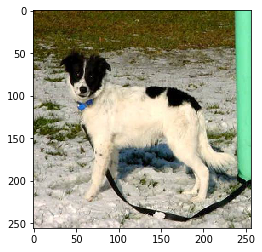

I am 66.91% sure this is a Cat


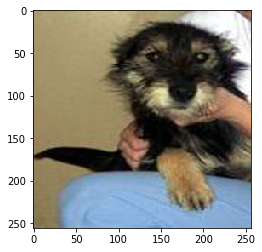

In [12]:
#####predict cat | predict dog


for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test2[i].T)
    plt.show()